# Querying Inferences

ArthurAI exposes a very flexible query interface so you can quickly slice and dice metrics about your model's inputs and outputs. In this notebook, we walk through a few examples of how data scientists might track a model's stability and metrics. 

These queries are conducted using a SQL-like language and the results can be easily dropped into a pandas DataFrame for plotting.

To learn more about the full details of what is possible, please view the [Query Guide and Documentation](https://docs.arthur.ai/api-documentation/query_guide.html). Many aggregations, transformations, and helper functions are available. 

In [1]:
import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from arthurai import ArthurAI
from arthurai.common.constants import Stage

In [2]:
# connect to Arthur
# UNCOMMENT the two lines below and enter your details
arthur = ArthurAI(
    # url="https://app.arthur.ai",  # you can also pass this through the ARTHUR_ENDPOINT_URL environment variable
    # login="<YOUR_USERNAME_OR_EMAIL>",  # you can also pass this through the ARTHUR_LOGIN environment variable
)
# arthur_model = arthur.get_model("RiskModel_v1.0.1", id_type="partner_model_id") 

## Model outputs over time
We might be interested in the stability/drift of the model's output predictions over time. We can summarize the classifier's average predicted probability (termed "prediction_1" below) and see how this changes from batch to batch.

In this example, we use the "avg" aggregator, as well as grouping by "batch_id".

([], [])

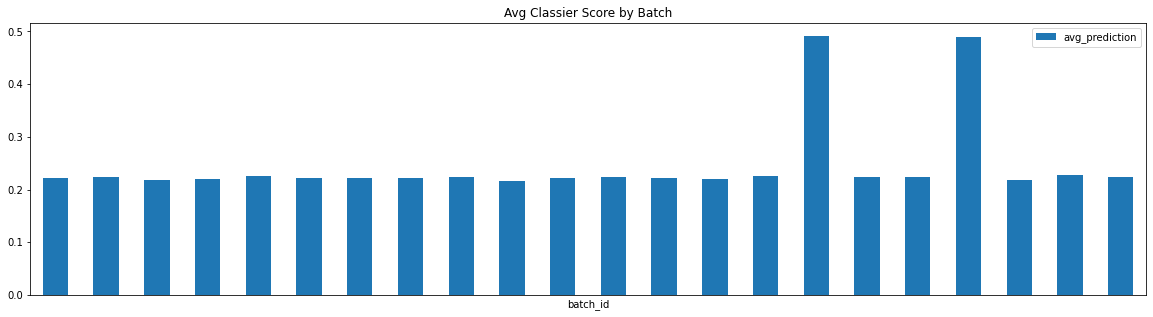

In [3]:
query = {
    "select": [
        {
            "function": "avg",
            "alias": "avg_prediction",
            "parameters": {
                "property": "prediction_1"
            }
        },
        {
            "property": "batch_id"
        }
    ],
    "group_by": [
        {
            "property": "batch_id"
        }
    ]
}
response = arthur_model.query(query)

pd.DataFrame(response).plot.bar(x="batch_id", y="avg_prediction", figsize=(20,5))
plt.title("Avg Classier Score by Batch")
plt.xticks([])

## Positive Rate over time
Instead of the average predicted score, we might be interested in something more explicit such as the classifier's resulting positive rate subject to a threshold. In this example, we use the "rate" function and supply a threshold for comparison.

Text(0.5, 1.0, 'Classifier Positive Rate per Batch at Threshold=0.7')

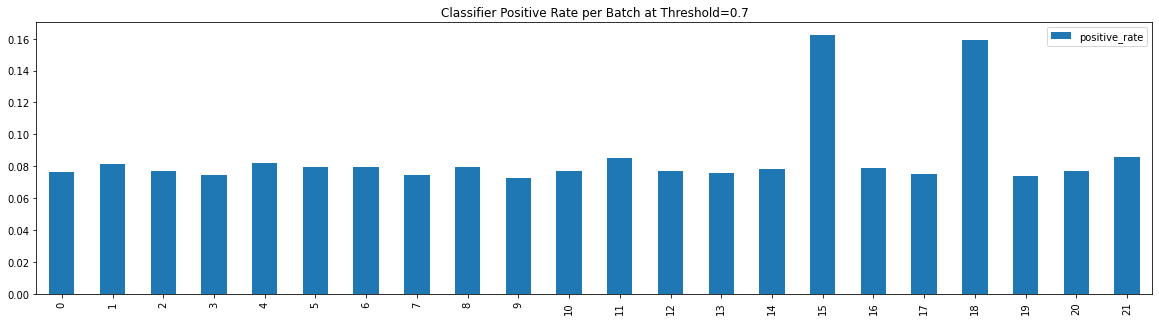

In [4]:
# positive rate
classifier_threshold = 0.7
query = {
    "select": [
        {
            "function": "rate",
            "alias": "positive_rate",
            "parameters": {
                "property": "prediction_1",
                "comparator": "gt",
                "value": classifier_threshold
            }
        },
        {
            "property": "batch_id"
        }
    ],
    "group_by": [
        {
            "property": "batch_id"
        }
    ]
}
response = arthur_model.query(query)

pd.DataFrame(response).plot.bar(figsize=(20,5))
plt.title(f"Classifier Positive Rate per Batch at Threshold={classifier_threshold}")

## Viziualizing the distribution of a categorical variable
We can also visualize the distribution of a variable over all observed infereces. For a categorical variable, we can use the "count" function. 

<AxesSubplot:xlabel='EDUCATION'>

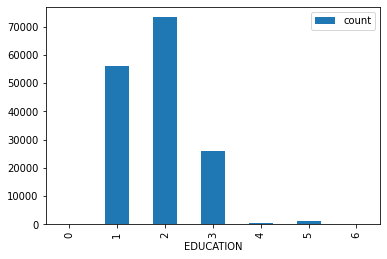

In [5]:
feature_name = "EDUCATION"
query = {
    "select": [
        {
            "property": feature_name
        },
        {
            "function": "count"
        }
    ],
    "group_by": [
        {
            "property": feature_name
        }
    ],
    "order_by": [
        {
            "property": feature_name
        }
    ]
}
response = arthur_model.query(query)

pd.DataFrame(response).plot.bar(x=feature_name)

## Viziualizing the distribution of a continuous variable
For a continous variable, we can use the [distribution](https://docs.arthur.ai/api-documentation/query_guide.html#distribution) function.

Text(0, 0.5, 'Count')

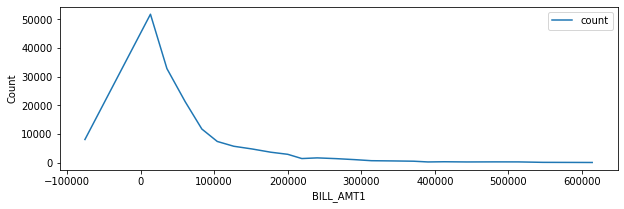

In [6]:
feature_name = "BILL_AMT1"
query =  {
    "select": [
        {
            "function": "distribution",
            "parameters": {
                "property": feature_name,
                "num_bins": 25
            }
        }
    ]
}
response = arthur_model.query(query)

pd.DataFrame(response[0]["distribution"]).plot.line(x="upper", y="count", figsize=(10,3))
plt.xlabel(feature_name)
plt.ylabel("Count")

## Time slicing
We can easily filter down to specific timeframes for comparison, using the "filter" operation.

<AxesSubplot:xlabel='EDUCATION'>

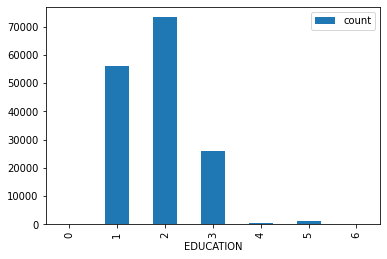

In [7]:
feature_name = "EDUCATION"

query = {
    "select": [
        {
            "property": feature_name
        },
        {
            "function": "count"
        }
    ],
    "filter": [
        {
            "property": "inference_timestamp",
            "comparator": "gte",
            "value": "2021-01-01T10:00:00Z"
        },
        {
            "property": "inference_timestamp",
            "comparator": "lt",
            "value": "2021-02-01T11:00:00Z"
        }
    ],
    "group_by": [
        {
            "property": feature_name
        }
    ],
    "order_by": [
        {
            "property": feature_name
        }
    ]
}
response = arthur_model.query(query)

pd.DataFrame(response).plot.bar(x="EDUCATION")

## Viziualizing the distribution of a variable over time
Or, we can visulize the distribution of a variable over time by using the "roundTimestamp" function to aggregate into time windows such as secondly, minutely, hourly, daily, or per batch.

<AxesSubplot:xlabel='second'>

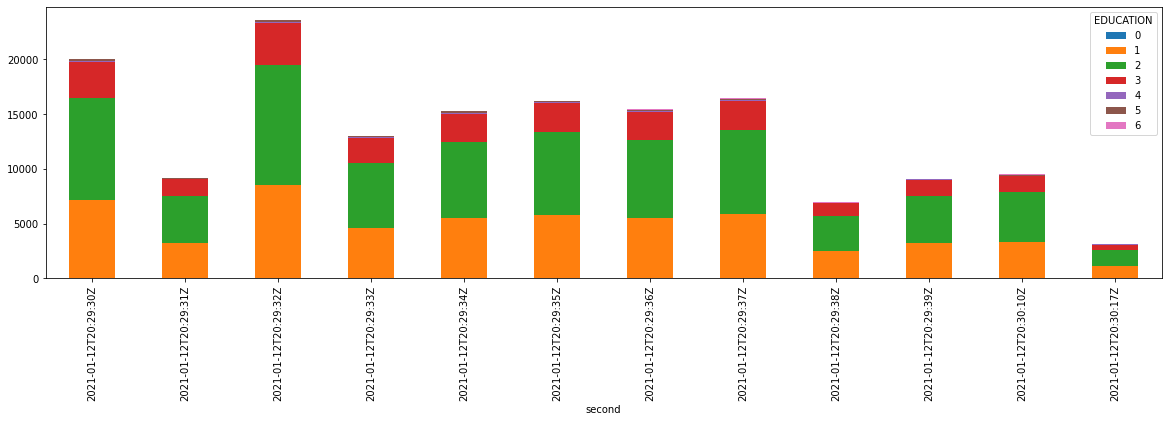

In [8]:
feature_name = "EDUCATION"
interval = "second"

query = {
    "select": [
        {
            "property": feature_name
        },
        {
            "function": "count"
        },
        {
            "function": "roundTimestamp",
            "alias": interval,
            "parameters": {
                "property": "inference_timestamp",
                "time_interval": interval
            }
        }
    ],
    "group_by": [
        {
            "property": feature_name
        },
        {
            "alias": interval
        }
    ],
    "order_by": [
        {
            "property": feature_name
        }
    ]
}
response = arthur_model.query(query)

pd.DataFrame(response).pivot(index=interval,columns=feature_name, values="count").plot.bar(figsize=(20,5), stacked=True)

## Predictions over time per demographic groups
We can also visualize a model's output predictions and segment and slice the data along any relevant dimensions. For example, let's look at the average prediction from a regression model, and group by another variable such as Gender. And we'll also group by "day" so we can see how this model's predictions drift over time.

Text(0, 0.5, 'Average Prediction')

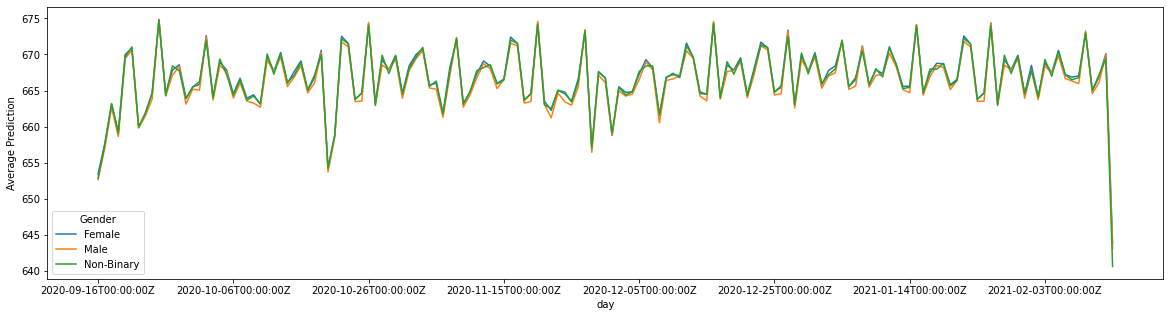

In [9]:
arthur_model = arthur.get_model("...")

query = {
    "select": [
        {
            "function": "avg",
            "alias": "average_prediction",
            "parameters": {
                "property": "Predicted_FICO_Score"
            }
        },
        {
            "function": "roundTimestamp",
            "alias": "day",
            "parameters": {
                "property": "inference_timestamp",
                "time_interval": "day"
            }
        },
        {
            "property": "Gender"
        }
    ],
    "group_by": [
        {
            "property": "Gender"
        },
        {
            "alias": "day"
        }
    ]
}
response = arthur_model.query(query)

pd.DataFrame(response).pivot(index="day",columns="Gender", values="average_prediction").plot.line(figsize=(20,5))
plt.ylabel("Average Prediction")

## A Multidimensional Query
The Query API can accomodate complex slicing and dicing. We'll look at Precision, by Marriage and exact Age, with the number of elements in the group denoted by point size, for all inferences over a two week period in which the Limit Balance is not greater than 500,000.

In [10]:
arthur_model = arthur.get_model("...")

# exactly one predicted attribute must have is_positive_predicted_attribute == True
predicted_attribute = [att for att in arthur_model.attributes
                       if att.stage == Stage.PredictedValue and att.is_positive_predicted_attribute][0]
# select the ground truth attribute linked to the predicted attribute
ground_truth_attribute = predicted_attribute.attribute_link

predicted_attribute = predicted_attribute.name

two_weeks_ago = (datetime.datetime.utcnow() - datetime.timedelta(days=14)).isoformat()

query = {
    "select": [
        {
            "property": "AGE"
        },
        {
            "property": "MARRIAGE"
        },
        {
            "function": "precision",
            "parameters": {
                "predicted_property": predicted_attribute,
                "ground_truth_property": ground_truth_attribute,
                "threshold": 0.5
            }
        },
        {
            "function": "count",
        }
    ],
    "group_by": [
        {
            "property": "AGE"
        },
        {
            "property": "MARRIAGE"
        }
    ],
    "filter": [
        {
            "property": "inference_timestamp",
            "comparator": "gte",
            "value": two_weeks_ago,
        },
        {
            "property": "LIMIT_BAL",
            "comparator": "lte",
            "value": 500_000,
        }
    ]
}
precision_by_age = arthur_model.query(query)

Text(0.5, 1.0, 'Precision vs Age by Marriage From Last Two Weeks Where Limit <= $500,000 With Counts')

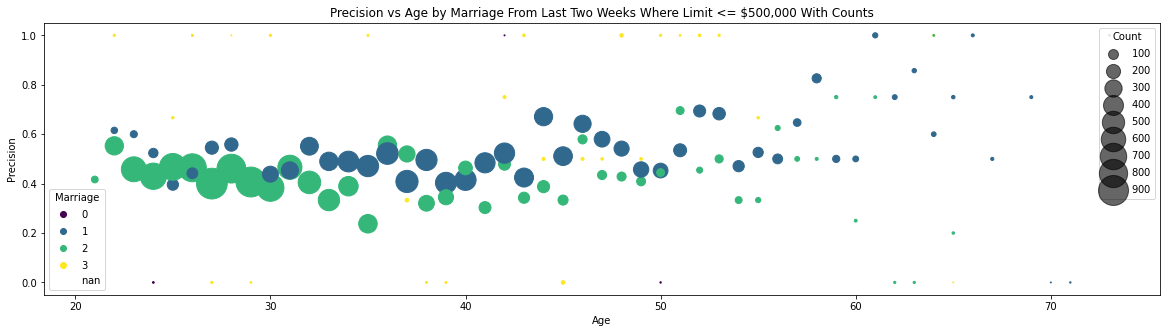

In [11]:
df = pd.DataFrame(precision_by_age)
fig, ax = plt.subplots(figsize=(20,5))
scatter = ax.scatter(x=df['AGE'], y=df['precision'], s=df['count'], c=df['MARRIAGE'])
legend1 = ax.legend(*scatter.legend_elements(), loc="lower left", title="Marriage")
ax.add_artist(legend1)
handles, labels = scatter.legend_elements(prop="sizes", alpha=0.6)
legend2 = ax.legend(handles, labels, loc="upper right", title="Count")
ax.set_xlabel("Age")
ax.set_ylabel("Precision")
ax.set_title("Precision vs Age by Marriage From Last Two Weeks Where Limit <= $500,000 With Counts")

# Feature Importance and Drift
We'll now look at queries involving feature importance and/or data drift. Let's first issue requests for each.

In [12]:
feature_importance_query = {
    "select": [
        {
            "function": "regionalFeatureImportances",
            "parameters": {
                "predicted_attribute_name": "prediction_1",
            },
        }
    ],
    "filter": [
        {
            "property": "inference_timestamp",
            "comparator": "gte",
            "value": "2021-01-26T10:00:00Z"
        },
        {
            "property": "inference_timestamp",
            "comparator": "lt",
            "value": "2021-01-28T10:00:00Z"
        }
    ],
    "from": "enriched",
}
feature_importance_response = arthur_model.query(feature_importance_query)

In [13]:
data_drift_query = {
    "properties": arthur_model.get_attribute_names(Stage.ModelPipelineInput),
    "num_bins": 10,
    "base": {
      "source": "reference",
    },
    "target": {
      "source": "inference",
      "filter": [
        {
          "property": "inference_timestamp",
          "comparator": "gte",
          "value": "2021-01-10T10:00:00Z"
        },
        {
          "property": "inference_timestamp",
          "comparator": "lt",
          "value": "2021-01-28T10:00:00Z"
        }
      ]
    },
  "metric": "HellingerDistance"
}
data_drift_response = arthur_model.query(data_drift_query, query_type='drift')

## Barplot of drift for all attributes

<AxesSubplot:xlabel='Attribute'>

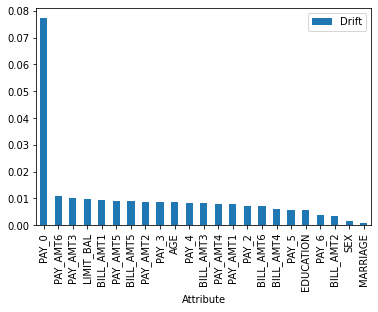

In [14]:
result = pd.DataFrame({"Attribute":data_drift_response[0].keys(), 
                      "Drift":data_drift_response[0].values()
                      })
result.sort_values(by="Drift", ascending=False).plot.bar("Attribute", "Drift")

## Feature Importance vs Drift

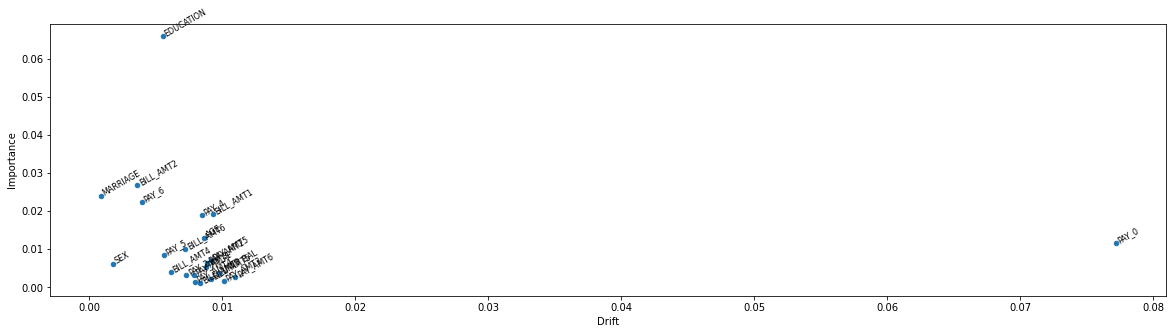

In [15]:
result = pd.DataFrame({"Attribute":data_drift_response[0].keys(), 
                      "Drift":data_drift_response[0].values(), 
                      "Importance":[item["avgAbs"] for item in feature_importance_response]  
                      })

result.plot.scatter("Drift", "Importance", figsize=(20,5))
for index, row in result.iterrows():
  plt.text(row["Drift"], row["Importance"], row["Attribute"], fontsize=8, rotation=30)

## Get Top 10 Features Then Grab Drift
Useful when you have a ton of features.

In [16]:
feature_importance_response =  arthur_model.query(feature_importance_query)
feature_importance_response.sort(key=lambda x: x['avgAbs'], reverse=True)
top_features = list(map(lambda x: x['explainer_attribute'], feature_importance_response[0:10]))
top_features

['PAY_0',
 'PAY_2',
 'PAY_3',
 'LIMIT_BAL',
 'PAY_AMT2',
 'PAY_AMT1',
 'PAY_AMT3',
 'PAY_5',
 'PAY_4',
 'PAY_6']

<AxesSubplot:xlabel='rollup'>

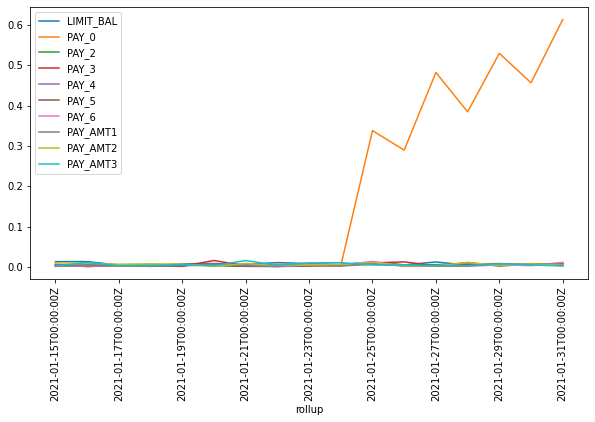

In [17]:
# get drift for top 10 features over january rolling up by day
top_data_drift_query = {
    "properties": top_features,
    "num_bins": 10,
    "rollup": "day",
    "base": {
      "source": "reference",
    },
    "target": {
      "source": "inference",
      "filter": [
        {
          "property": "inference_timestamp",
          "comparator": "gte",
          "value": "2021-01-01T00:00:00Z"
        },
        {
          "property": "inference_timestamp",
          "comparator": "lt",
          "value": "2021-02-01T00:00:00Z"
        }
      ]
    },
  "metric": "PSI"
}
top_data_drift_response = ar_model.query(top_data_drift_query, query_type='drift')
pd.DataFrame(top_data_drift_response).set_index("rollup").sort_values("rollup").plot.line(rot=90, figsize=(10,5))

# Create Alert Rule
I want to create a custom alert based on this metric above, so I am automatically informed in the future.

In [18]:
# arthur_model.create_alert_rule(attribute_name="PAY_0",
#                                bound="upper",
#                                threshold=0.5,
#                                metric="PSI Data Drift Reference Set",
#                                severity="critical",
#                                lookback_period=60*24,
#                                subsequent_alert_wait_time=60*12,
#                                enabled=True)

# output with ids hidden: AlertRule(bound='upper', threshold=0.5, metric='PSI Data Drift Reference Set', severity='critical', query={'base': {'source': 'reference'}, 'num_bins': 20, 'properties': [], 'target': {'source': 'inference'}}, lookback_period=1440, subsequent_alert_wait_time=720, check_batch_idle_time=None, attribute_id='..., attribute_name='PAY_2', enabled=True, id='...')

# Explanations

## Global Explanations
We can easily query the average magnitude of importance for each attribute across all historical inferences

<AxesSubplot:title={'center':'Average Absolute Explanation Score (All Time)'}, xlabel='explainer_attribute'>

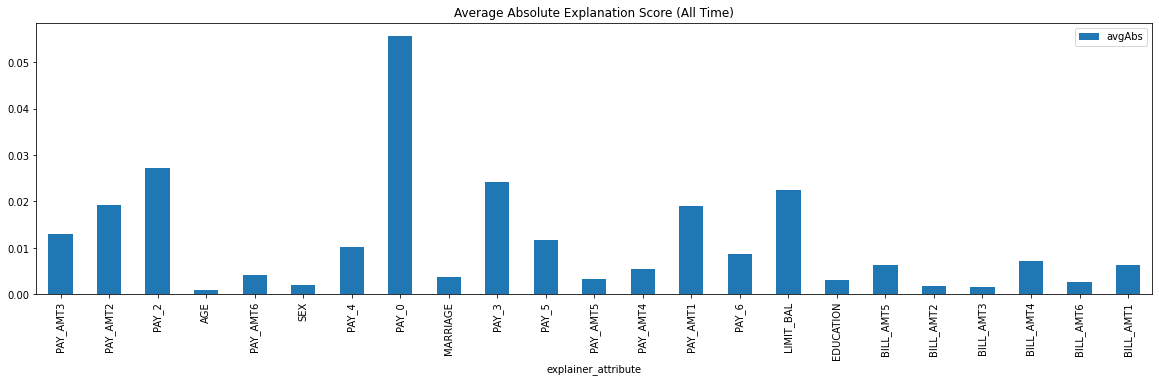

In [19]:
# exactly one attribute must have is_positive_predicted_attribute == True
predicted_attribute = [att.name for att in arthur_model.attributes
                       if att.stage == Stage.PredictedValue and att.is_positive_predicted_attribute][0]

query = {
    "select": [
        {
            "function": "regionalFeatureImportances",
            "parameters": {
                "predicted_attribute_name": predicted_attribute,
            },
        },
    ],
    "from": "enriched",
}
global_explanations = arthur_model.query(query)

pd.DataFrame(global_explanations).plot.bar(x="explainer_attribute", y="avgAbs", title=f"Average Absolute Explanation Score (All Time)", figsize=(20,5))

## Global Explanations over time

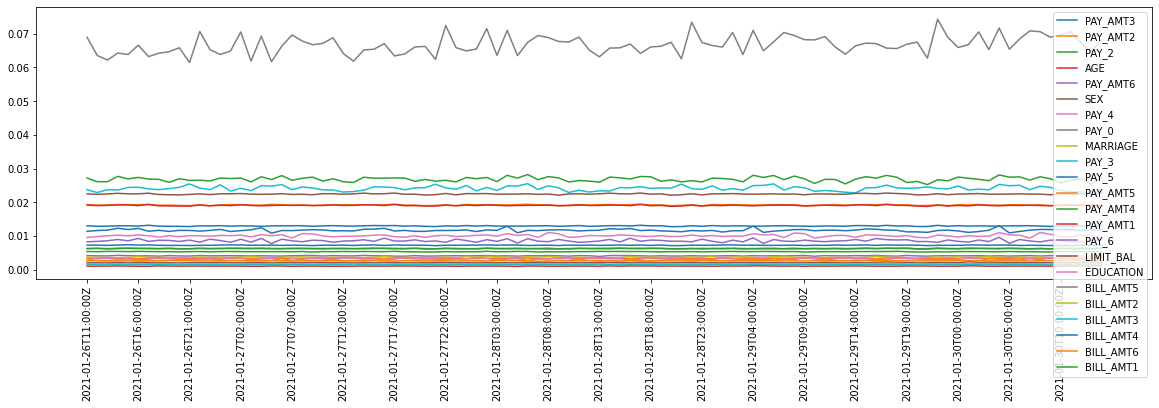

In [20]:
base_hour = datetime.datetime.strptime("2021-01-26T10:00:00Z", "%Y-%m-%dT%H:%M:%SZ")
n_hours = 100
hour_pairs = [(datetime.datetime.strftime(base_hour + datetime.timedelta(hours=i), "%Y-%m-%dT%H:%M:%SZ"), datetime.datetime.strftime(base_hour + datetime.timedelta(hours=i+1), "%Y-%m-%dT%H:%M:%SZ")) for i in range(n_hours)]

results = {}
for start_hour, end_hour in hour_pairs:
  body = {
      "select": [
          {
              "function": "regionalFeatureImportances",
              "parameters": {
                  "predicted_attribute_name": "prediction_1",
              },
          }
      ],
      "filter": [
          {
              "property": "inference_timestamp",
              "comparator": "gte",
              "value": start_hour
          },
          {
              "property": "inference_timestamp",
              "comparator": "lt",
              "value": end_hour
          }
      ],
      "from": "enriched",

  }
  result = {}
  for resp in arthur_model.query(body): 
    result[resp["explainer_attribute"]] = resp["avgAbs"]
    results[end_hour] = result
df = pd.DataFrame.from_dict(results, orient="index")
df.plot(figsize=(20, 5), rot=90)
idxs = range(0, len(df.index), 5)
_ = plt.xticks(idxs, df.index[idxs])

## Explanations for Specific Inferences
Explanations can be retreived for any specific inferences on hand.

In [21]:
def explanation_for_inferences(model, inference_ids, only_attributes=None):
  # default to all pipeline input attributes
  if only_attributes is None:
    attributes = [att.name for att in model.attributes if att.stage == Stage.ModelPipelineInput]
  else:
    attributes = only_attributes
  # exactly one attribute must have is_positive_predicted_attribute == True
  predicted_attribute = [att.name for att in model.attributes
                         if att.stage == Stage.PredictedValue and att.is_positive_predicted_attribute][0]

  query = {
      "filter": [
          {
              "property": "inference_id",
              "comparator": "in",
              "value": inference_ids,
          },
          {
              "property": "explainer_attribute",
              "comparator": "in",
              "value": attributes,
          },
          {
              "property": "explainer_predicted_attribute",
              "comparator": "eq",
              "value": predicted_attribute,
          },
      ],
      "select": [
          {
              "property": "inference_id",
          },
          {
              "property": "explainer_algo",
          },
          {
              "property": "explainer_attribute",
          },
          {
              "property": "explainer_score",
          },
          {
              "property": "explainer_predicted_attribute",
          },
      ],
      "from": "enriched",
  }
  return model.query(query)

In [22]:
# we might want to inspect some specific inferences, we'll grab the first three inferences but we could select them any way
query = {
    "select": [
        {
            "property": "inference_id"
        },
    ],
    "order_by": [
        {
            "property": "inference_timestamp",
        },
    ],
}
inference_ids = [res['inference_id'] for res in arthur_model.query(query)[:3]]

In [23]:
explanations = pd.DataFrame(explanation_for_inferences(arthur_model, inference_ids))
one_explanation = explanations[explanations['inference_id'] == explanations.iloc[0]['inference_id']]

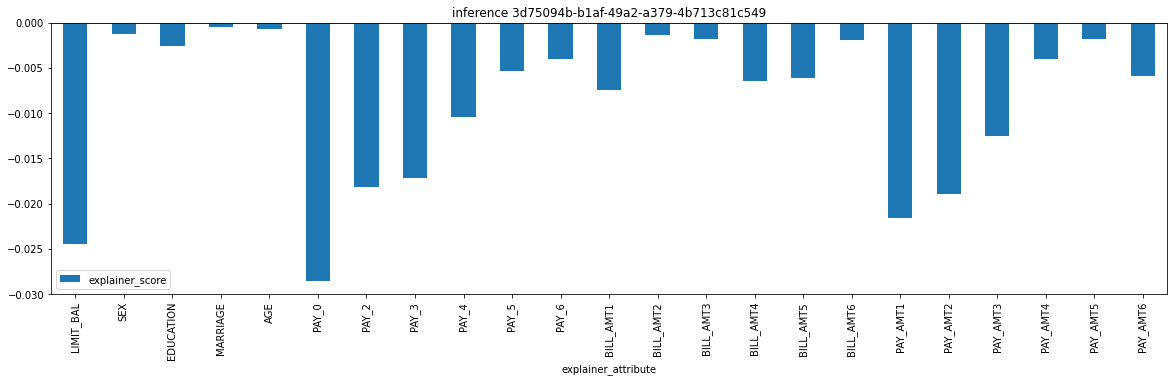

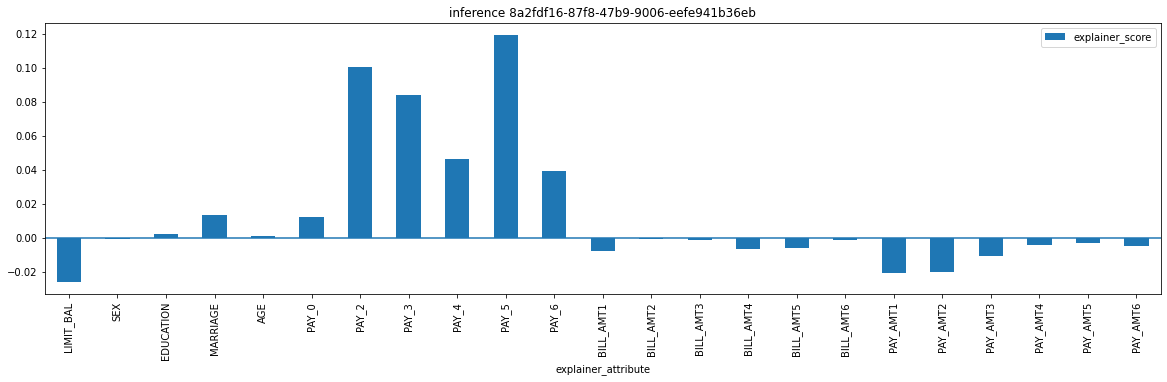

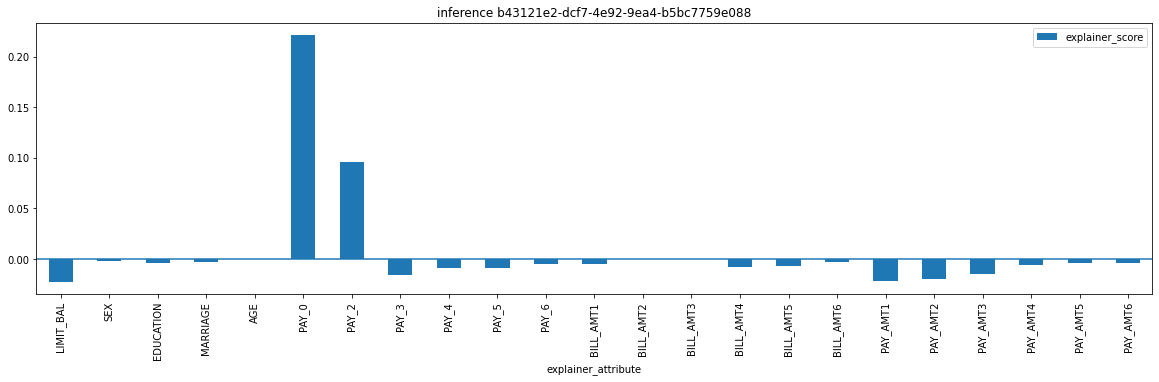

In [24]:
for inference_id, group in explanations.groupby("inference_id"):
  group.plot.bar(x="explainer_attribute", y="explainer_score", title=f"inference {inference_id}", figsize=(20,5))
  plt.hlines(0, -1, len(arthur_model.attributes))